In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [2]:
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'difficulty_level'  # Added to match the 44 columns
]

train_data = pd.read_csv('archive/KDDTrain+.txt')
test_data = pd.read_csv('archive/KDDTest+.csv')
test_data = test_data.drop('Unnamed: 0', axis=1)
train_data.columns = column_names
test_data.columns = column_names

In [3]:
print(test_data.head())

   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         2           tcp  ftp_data    SF      12983          0     0   
2         0          icmp     eco_i    SF         20          0     0   
3         1           tcp    telnet  RSTO          0         15     0   
4         0           tcp      http    SF        267      14515     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.00   
1               0       0    0  ...                    0.61   
2               0       0    0  ...                    1.00   
3               0       0    0  ...                    0.31   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.06                         0.00   
1                    0.04                         0.61   
2       

In [4]:
cols_to_drop = ['num_outbound_cmds', 'is_host_login', 'difficulty_level']
train_data = train_data.drop(cols_to_drop, axis=1)
test_data = test_data.drop(cols_to_drop, axis=1)

In [5]:
def preprocess_categorical(df):
    # Protocol type (3 categories)
    df = pd.get_dummies(df, columns=['protocol_type'], prefix='proto')
    
    # Flag (11 categories)
    df = pd.get_dummies(df, columns=['flag'], prefix='flag')
    
    # Service (keep top 10 + others)
    top_services = df['service'].value_counts().nlargest(10).index.tolist()
    df['service'] = df['service'].apply(lambda x: x if x in top_services else 'other')
    df = pd.get_dummies(df, columns=['service'], prefix='srv')
    
    return df

train_data = preprocess_categorical(train_data)
test_data = preprocess_categorical(test_data)

In [6]:
train_cols = train_data.columns
test_data = test_data.reindex(columns=train_cols, fill_value=0)

In [7]:
X_train = train_data.drop('attack_type', axis=1)
y_train = train_data['attack_type']
X_test = test_data.drop('attack_type', axis=1)
y_test = test_data['attack_type']

In [8]:
print(X_test['duration'])
print("dtype:", X_test['duration'].dtype)

0        0
1        2
2        0
3        1
4        0
        ..
22538    0
22539    0
22540    0
22541    0
22542    0
Name: duration, Length: 22543, dtype: int64
dtype: int64


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
pca = PCA(n_components=24)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [11]:
X_train_reshaped = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
X_test_reshaped = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

In [12]:
encoder = LabelBinarizer()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [13]:
y_train_classes = np.argmax(y_train_encoded, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weights_dict = dict(enumerate(class_weights))

In [14]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', 
           input_shape=(24, 1), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(filters=64, kernel_size=2, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.4),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(y_train_encoded.shape[1], activation='softmax')
])


optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 32)            128       
                                                                 
 batch_normalization (Batch  (None, 22, 32)            128       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            4160      
                                                                 
 batch_normalization_1 (Bat  (None, 10, 64)           

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
history = model.fit(
    X_train_reshaped,
    y_train_encoded,
    epochs=50,  # Increased to allow early stopping
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/50


788/788 [==============================] - 6s 5ms/step - loss: 7.8032 - accuracy: 0.0333 - val_loss: 3.5773 - val_accuracy: 0.0147
Epoch 2/50
788/788 [==============================] - 4s 5ms/step - loss: 6.8330 - accuracy: 0.0368 - val_loss: 3.5386 - val_accuracy: 0.0161
Epoch 3/50
788/788 [==============================] - 4s 5ms/step - loss: 6.3146 - accuracy: 0.0392 - val_loss: 3.4161 - val_accuracy: 0.0155
Epoch 4/50
788/788 [==============================] - 4s 5ms/step - loss: 6.2407 - accuracy: 0.0403 - val_loss: 3.4031 - val_accuracy: 0.0199
Epoch 5/50
788/788 [==============================] - 4s 5ms/step - loss: 5.9772 - accuracy: 0.0419 - val_loss: 3.3663 - val_accuracy: 0.0183
Epoch 6/50
788/788 [==============================] - 4s 5ms/step - loss: 5.2871 - accuracy: 0.0429 - val_loss: 3.3244 - val_accuracy: 0.0253
Epoch 7/50
788/788 [==============================] - 4s 5ms/step - loss: 5.0974 - accuracy: 0.0451 - val_loss: 3.2907 - val_accuracy: 0.0238
Epoc

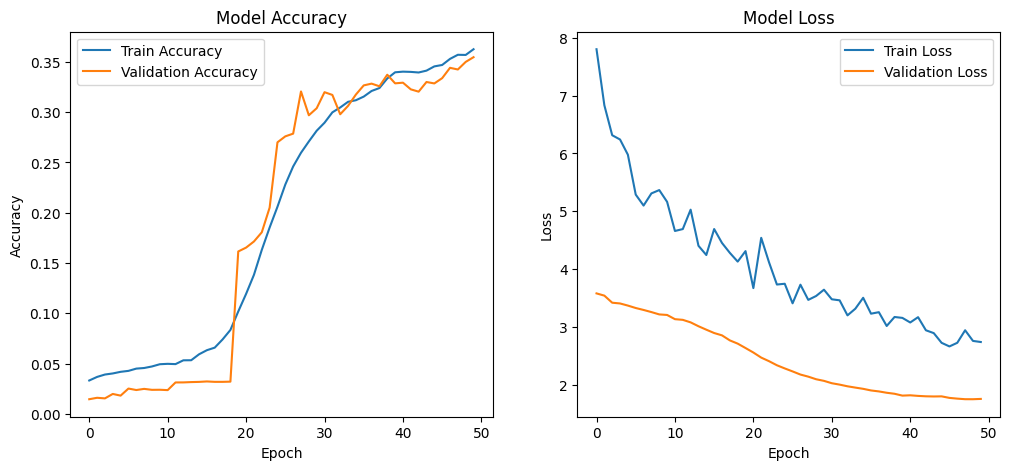

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
print(f'\nTest Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')


Test Accuracy: 0.1997
Test Loss: 1.6571


In [19]:
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

print('\nClassification Report:')
print(classification_report(y_test_classes, y_pred_classes, labels=np.arange(len(encoder.classes_)), target_names=encoder.classes_))

705/705 [==============================] - 1s 1ms/step

Classification Report:
                 precision    recall  f1-score   support

           back       0.07      0.14      0.10      4109
buffer_overflow       0.00      0.00      0.00        20
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.38      0.13      0.19      1231
           imap       0.00      0.00      0.00         1
        ipsweep       0.99      0.96      0.98       141
           land       0.37      1.00      0.54         7
     loadmodule       0.18      1.00      0.31         2
       multihop       0.00      0.00      0.00        18
        neptune       0.88      0.46      0.61      4656
           nmap       0.00      0.00      0.00        73
         normal       0.29      0.00      0.00      9711
           perl       0.12      0.50      0.20         2
            phf       0.03      0.50      0.06         2
            pod       0.02      0.98      0.04        41
      po

c:\Users\ishan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ishan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ishan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

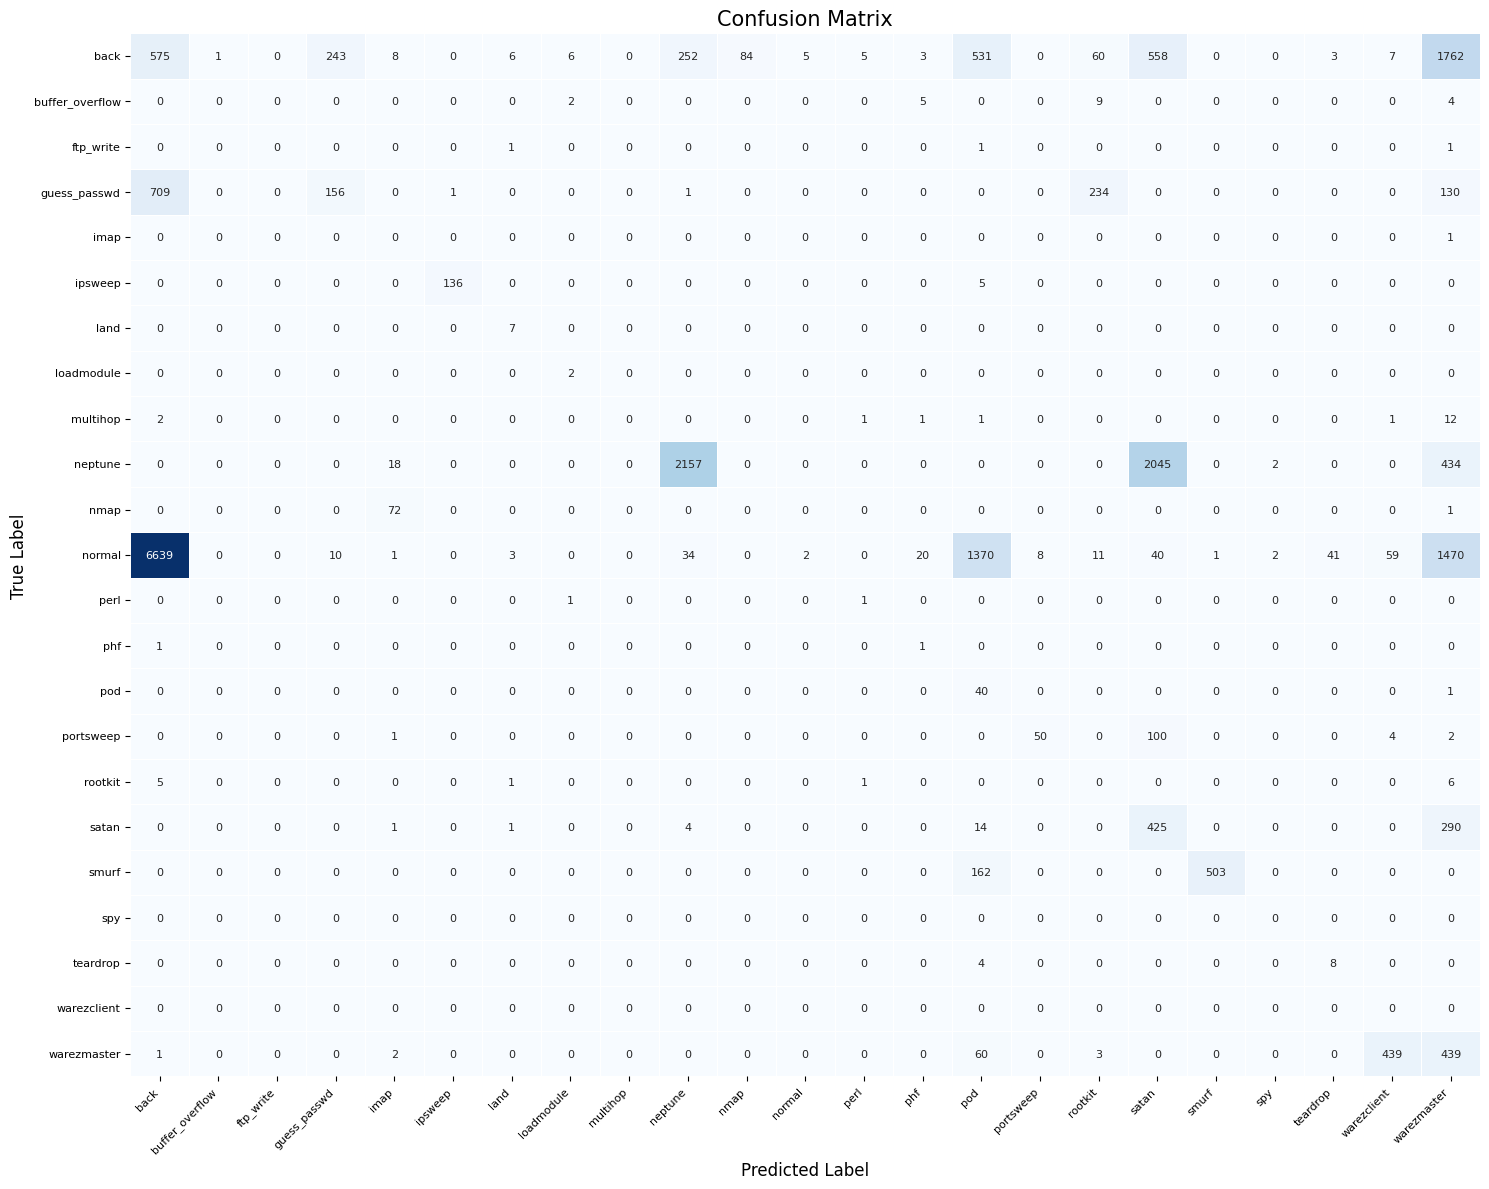

In [22]:
# Adjust the confusion matrix to match the number of classes
num_classes = len(encoder.classes_)
adjusted_cm = np.zeros((num_classes, num_classes), dtype=int)
adjusted_cm[:cm.shape[0], :cm.shape[1]] = cm

cm_df = pd.DataFrame(adjusted_cm, 
                     index=encoder.classes_, 
                     columns=encoder.classes_)

plt.figure(figsize=(15, 12))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', 
            cbar=False, linewidths=.5, annot_kws={"size": 8})
plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()